In [1]:
import os, getpass
from typing import override
from langchain import hub
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from dotenv import load_dotenv
import datetime
import pytz
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
load_dotenv(override=True)

True

In [2]:
# Create the LLM
llm = ChatOpenAI(
    base_url="https://api.anthropic.com/v1/",
    api_key=os.environ["ANTHROPIC_API_KEY"],  # Your Anthropic API key
    model="claude-opus-4-20250514"
)

# Use invoke
# response = llm.invoke([
#     SystemMessage(content="You are a helpful assistant."),
#     HumanMessage(content="Who is the Prime Minister of India")
# ])

# print(response.content)

C:\Users\sunit\AppData\Local\Temp\ipykernel_31064\3647267280.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


In [3]:
from pydantic import BaseModel, Field
from typing import List, Optional
from langchain_core.documents import Document

class State(BaseModel):
    # --- Inputs provided when the graph starts ---
    question: str
    work_experience: int
    job_skills: List[str]

    # --- Fields that will be populated during the graph's run ---
    # These are optional and have default values.
    context: List[Document] = Field(default_factory=list)
    work_ex_rating: Optional[int] = None
    skills_rating: Optional[int] = None
    answer: Optional[str] = None
    experience_level: Optional[str] = None 
    skill_match: Optional[str] = None 

In [4]:
from src.RAG import ResumeRAG

def analyze_resume(state: State):
    rag_pipeline = ResumeRAG(folder_path="docs", llm=llm)
    candidate_ratings = rag_pipeline.rate_candidate(
        required_experience_years = state.work_experience,
        required_skills_list = state.job_skills
    )
    return {
        "work_ex_rating": candidate_ratings['work_ex_rating'],
        "skills_rating": candidate_ratings['skills_rating']
    }
    

In [5]:
# Perform RAG on the resume 
workflow = StateGraph(State)

In [6]:
def categorize_application(state: State) -> State:
    print("\n Categorizing the experienc level of candidate")
    experience_level = None
    if state.work_ex_rating is not None:
        if 0 <= state.work_ex_rating <= 4:
            experience_level = 'junior-level'
        elif 5 <= state.work_ex_rating <= 8:
            experience_level = 'mid-level'
        elif state.work_ex_rating > 8:
            experience_level = 'senior-level'
    
    print(f"Categorized experience as: {experience_level}")
    return {"experience_level": experience_level}

In [7]:
def assessing_skillset(state: State) -> State:
    print("\n Assessing skillset of candiadte")
    skill_match = None
    if state.skills_rating is not None:
        if 0 <= state.skills_rating <= 4:
            skill_match = 'low'
        elif 5 <= state.skills_rating <= 8:
            skill_match = 'medium'
        elif state.skills_rating > 8:
            skill_match = 'high'
    print(f"Assessed skill match as: {skill_match}")
    return {"skill_match": skill_match}

In [8]:
from src.meeting_scheduler import MeetingScheduler, TIMEZONE
from src.RAG import extract_email_from_text, get_text_from_pdf

def schedule_hr_interview(state: State) -> State:
    print("Schedule hr interview")
    # --- DEFINE YOUR MEETING DETAILS HERE ---
    summary = "Scheduling HR interview of candidate"
    description = "One-on-one intercation with HR"

    resume_text_content = get_text_from_pdf('docs/RESUME.pdf')

    if resume_text_content:
        email = extract_email_from_text(resume_text_content)        
        if email:
            print(f"✅ Email Address Found: {email}")
        else:
            print("❌ No email address found in the document.")

                
    # Set timezone
    tz = pytz.timezone(TIMEZONE)

    # Set start and end times (e.g., August 5, 2025, from 2:00 PM to 3:30 PM)
    start_time = tz.localize(datetime.datetime(2025, 8, 5, 14, 0, 0))
    end_time = tz.localize(datetime.datetime(2025, 8, 5, 15, 30, 0))

    # --- SCHEDULING ---
    # 1. Create an instance of the MeetingScheduler class
    scheduler = MeetingScheduler(
        summary=summary,
        description=description,
        start_time=start_time,
        end_time=end_time,
        attendees=[email]
    )

    scheduler.schedule()
    
    return {"response": "Candidate has skills matching to the job requirements"}

In [9]:
def escalate_to_recruiter(state: State) -> State:
    print("Schedule hr interview")
    return {"response": "Candidate has senior-level experience but doesn't match job requirement"}

In [10]:
from src.email_candidate import send_email
def reject_application(state: State) -> State:
    print("Rejecting application")
    resume_text_content = get_text_from_pdf('docs/RESUME.pdf')
    if resume_text_content:
        email = extract_email_from_text(resume_text_content)        
        if email:
            print(f"✅ Email Address Found: {email}")
        else:
            print("❌ No email address found in the document.")
    candidate_email = email
    email_subject = "Catching Up"
    email_body = "We regret to inform you that your application is rejected"
    sender = "choudhuryjayraj@gmail.com"
    
    send_email(recipient=candidate_email, sender=sender, subject=email_subject, body=email_body)
    return {"response": "Candidate does not match JD requirements"}

In [11]:
workflow.add_node("analyze_resume", analyze_resume)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)
workflow.add_node("categorize_application", categorize_application) 
workflow.add_node("assessing_skillset", assessing_skillset)

In [12]:
def route_app(state: State) -> str:
    print("\n---Routing application...---")
    skill_match = state.skill_match
    experience_level = state.experience_level
     # A more robust logical flow
    if skill_match == 'high':
        print("Decision: High skill match -> Schedule HR Interview")
        return "schedule_hr_interview"
    
    # Corrected the case from "senior-Level" to "senior-level"
    elif experience_level == 'senior-level' and skill_match == 'medium':
        print("Decision: Senior level with medium skills -> Escalate to Recruiter")
        return "escalate_to_recruiter"
        
    elif skill_match == 'medium':
        print("Decision: Medium skill match (non-senior) -> Schedule HR Interview")
        return "schedule_hr_interview"
        
    else:
        # This will catch 'low' skill match or any other case
        print("Decision: Low skill match -> Reject Application")
        return "reject_application"

In [13]:

workflow.add_conditional_edges("assessing_skillset", route_app, {
    "schedule_hr_interview": "schedule_hr_interview",
    "reject_application": "reject_application",
    "escalate_to_recruiter": "escalate_to_recruiter"
})

In [14]:
workflow.add_edge(START, "analyze_resume")
workflow.add_edge("analyze_resume", "categorize_application")
workflow.add_edge("categorize_application", "assessing_skillset")
workflow.add_edge("reject_application", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("assessing_skillset", END)

In [15]:
app = workflow.compile()

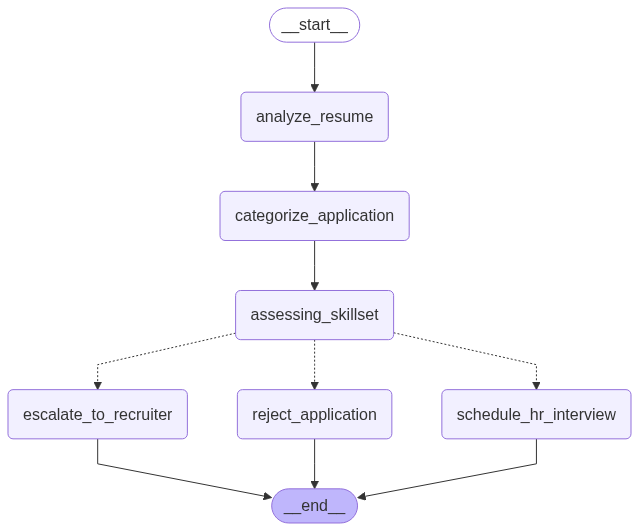

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
def run_candidate_screening(initial_state: dict):
    # Pass the entire dictionary to the invoke method
    results = app.invoke(initial_state)
    return {
        "work_ex_rating": results.get("work_ex_rating"),
        "skill_match": results.get("skills_rating"), # Assuming skill_match comes from skills_rating
        "response": results.get("answer") # Assuming response comes from the 'answer' key
    }

In [18]:
# Assume 'vectorstore' and 'llm' are already configured


# --- 1. Define your dynamic parameters ---
required_experience_years = int(input("Enter no. of years of work ex required"))
required_skills_list = list(map(str, input("Enter the skillset required").split()))
required_skills_str = ", ".join(required_skills_list)

# Dynamic query
question = (
    f"A candidate with at least {required_experience_years} years of work experience "
    f"and expertise in {required_skills_str}."
)

initial_state_dict = {
    "question": question,
    "work_experience": required_experience_years,
    "job_skills": required_skills_list
}


results = run_candidate_screening(initial_state_dict)

print("\n\nComputed Results :")
print(f"Application: {question}")
# print(f"Experience Level: {results['experience_level']}")
# print(f"Skill Match: {results['skill_match']}")
# print(f"Response: {results['response']}")

print(results)

Loading documents from: docs
Loaded 1 documents.
Split documents into 5 chunks.


j:\Projects\AI Agent Recruitment Agency\src\RAG.py:55: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
j:\Projects\AI Agent Recruitment Agency\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating vector database...


j:\Projects\AI Agent Recruitment Agency\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Vector database created successfully.

Retrieving documents for query: 'A candidate with at least 2 years of work experience and expertise in Java,, Kotlin,, Angular,, PHP,, Azure,, Databricks.'
Invoking LLM to generate ratings...


j:\Projects\AI Agent Recruitment Agency\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Categorizing the experienc level of candidate
Categorized experience as: junior-level

 Assessing skillset of candiadte
Assessed skill match as: low

---Routing application...---
Decision: Low skill match -> Reject Application
Rejecting application
✅ Email Address Found: jayraj.c26PGAI@jioinstitute.edu.in
Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=249399055390-h02ga0mon7onf0toph0lipms30pfmgep.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A57011%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.send&state=XgzgQVgqc3Da1iLg9CEH5UIZpiJbdg&access_type=offline
✅ Email sent successfully! Message ID: 19892842e04c9c80


Computed Results :
Application: A candidate with at least 2 years of work experience and expertise in Java,, Kotlin,, Angular,, PHP,, Azure,, Databricks.
{'work_ex_rating': 0, 'skill_match': 0, 'response': None}
